In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
from keras import backend as K
import tensorflow as tf

grad-cam

In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
model = VGG16(weights='imagenet')
img_path = '/content/cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

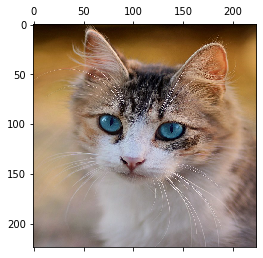

In [21]:
plt.matshow(img)

In [4]:
preds = model.predict(x)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [5]:
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02123045', 'tabby', 0.4991389), ('n02123159', 'tiger_cat', 0.32359195), ('n02124075', 'Egyptian_cat', 0.123756625)]


In [6]:
np.argmax(preds[0])

281

In [7]:
cat_output = model.output[:, 281]

In [8]:
last_conv_layer = model.get_layer('block5_conv3')

In [9]:
grads = K.gradients(cat_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2)) # each entry is the mean intensity of the gradient over a specific feature-map channel

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
# Multiplies each channel in the feature-map array by “how important this channel is” with regard to the “elephant” class
# "effects of pixels" but the gradient is pooled over channels

heatmap = np.mean(conv_layer_output_value, axis=-1) # channel-wise mean

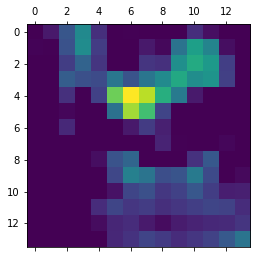

In [16]:
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

superimpose the original image on the heatmap

In [ ]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
plt.matshow(superimposed_img)
cv2.imwrite('/content/cat.jpg', superimposed_img)

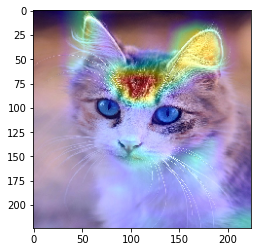

In [27]:
superimposed_imgpath = '/content/cat.jpg'
superimposed_img_load_img = image.load_img(superimposed_imgpath, target_size=(224, 224))
plt.imshow(superimposed_img_load_img)